# Analysis of predictions 
- Plot figures for analysis of predictions in the paper.

In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter 
import sys 
import os
import glob 
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
from cmcrameri import cm as cmap_cm
import sys
sys.path.append("../../")
from zeobind.src.utils.utils import setup_mpl, format_axs, get_color_values, get_cb
setup_mpl()
import warnings
warnings.filterwarnings("ignore")
colors = get_color_values(10, cmap_cm.lipari)
colors = [np.array(x) for x in colors]

In [2]:
prior_dir = "../../data/hyp_mols_data" 
pred_dir = "../../data/predictions/hyp_mols"
stats_op_dir = "../../data/publication/statistics"
source_data_dir = "../../source_data"

# Read files

In [3]:
truth = pd.read_csv("../../data/datasets/training_data/training_data.csv", index_col=0)

In [4]:
zpriors = pd.read_pickle("../../data/datasets/training_data/zeolite_priors_0.pkl")

In [5]:
split_dir = "../../data/datasets/training_data/splits/1"
train_val_smiles = [] 
for lab in ['train', 'val']:
    train_val_smiles.append(np.load(f"{split_dir}/smiles_{lab}.npy"))
train_val_smiles = np.concatenate(train_val_smiles)
print(len(train_val_smiles), len(set(truth['SMILES'])))

2675 2974


# Rest of the notebook analyses train+val data only

In [6]:
print(truth.shape, truth[truth['Binding (SiO2)'].lt(0.0)].shape)
truth = truth.loc[truth['SMILES'].isin(train_val_smiles)]
print(truth.shape, truth[truth['Binding (SiO2)'].lt(0.0)].shape)

(614263, 74) (353593, 74)
(552879, 74) (320002, 74)


- Use scripts in `zeobind/run_scripts/statistics/1.sh` and `zeobind/src/utils/statistics` to select the best and second best framework for each molecule, and then to calculate the BE on a per-OSDA basis for them. The following cells analyze the outputs from these scripts.

In [33]:
# Read in statistics files for monoquaternary 

mono_files = glob.glob(f"{stats_op_dir}/mono/*.csv")
print(len(mono_files))
mono_dfs = [pd.read_csv(f, index_col=0) for f in mono_files]
mono_df = pd.concat(mono_dfs)

55


In [35]:
# Read in statistics files for diquaternary

di_files = glob.glob(f"{stats_op_dir}/diq/*.csv")
print(len(di_files))
di_dfs = [pd.read_csv(f, index_col=0) for f in di_files]
di_df = pd.concat(di_dfs)

180


# Analysis

## Project dataset
- To understand the predictions we need to look at distributions in the project dataset first. 

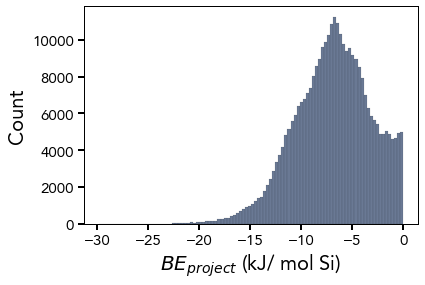

In [26]:
ee = truth[truth['Binding (SiO2)'] < 0.0][['Zeolite', 'SMILES', 'Binding (SiO2)']]
fig, axs = plt.subplots()
axs.hist(ee['Binding (SiO2)'], bins=100, color=colors[2], edgecolor='k', alpha=0.8, linewidth=0.1);
axs = format_axs(axs, 15, 15, 1, "$BE_{project}$ (kJ/ mol Si)", "Count", 20, 20)

### Possible correlations

In [12]:
def plot_correlations(truth, x_col='framework_density', x_label="Framework density ($T/1000 \AA^3$)", be_type="avg", ann_coords=(0.05, 0.8)):
    for elabel in ['Binding (SiO2)', 'Binding (OSDA)']:
        units = elabel.split('(')[1].split(')')[0]

        tt = truth[truth[elabel].lt(0.0)]
        if be_type == "avg":
            t = tt[['Zeolite', elabel]].groupby('Zeolite').mean()
        elif be_type == "min":
            t = tt[['Zeolite', elabel]].groupby('Zeolite').min()

        y = t[elabel]
        x = zpriors.loc[t.index, x_col]
        # c = zpriors.loc[t.index, 'largest_included_sphere']
        c = tt[['Zeolite', elabel]].groupby('Zeolite').std()[elabel].loc[t.index]
        # return x, y, c
        fig, axs = plt.subplots(figsize=(8, 4))
        sc = axs.scatter(x, y, c=c);

        if be_type == "avg":
            y_label = "$BE_{avg \; for \; a \; framework}$" + f" (kJ/ mol {units})"
        elif be_type == "min":
            y_label = "$BE_{min \; for \; a \; framework}$" + f" (kJ/ mol {units})"
        else:
            raise ValueError("Invalid be_type")

        axs = format_axs(axs, 15, 15, 1, x_label, y_label, 15, 15)
        cb = get_cb(fig, sc, axs, "$BE_{std \; for \; a \; framework}$" + f" (kJ/ mol {units})", linewidth=1, labelsize=12, cmap=cmap_cm.lipari)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x.values.tolist(), y.values.tolist())
        axs.plot(x, slope*x + intercept, '--k', linewidth=2, dashes=(6,6));
        axs.annotate(f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$= {r_value**2:.2f}", ann_coords, xycoords='axes fraction', fontsize=15);

        os.makedirs(f"{stats_op_dir}/correlations", exist_ok=True)
        fig.savefig(f"{stats_op_dir}/correlations/{elabel}_{x_col}_be{be_type}.png", dpi=300, bbox_inches='tight')

#### BE_min-FW density

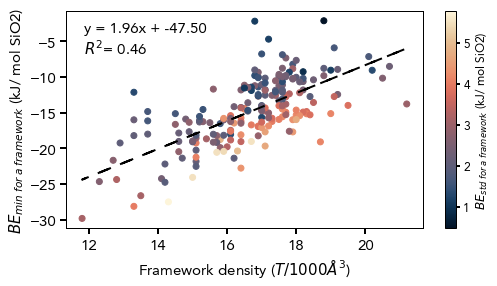

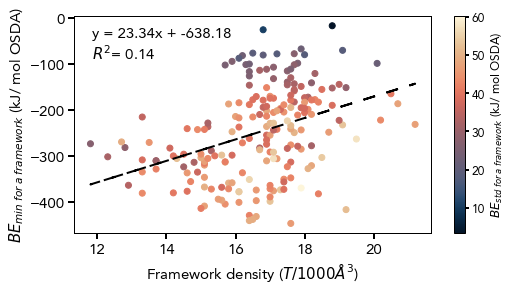

In [13]:
plot_correlations(truth, 'framework_density', "Framework density ($T/1000 \AA^3$)", "min", (0.05, 0.8))

In [14]:
# Look at possible correlation of stronger BEs having higher std devs

elabel = 'Binding (SiO2)'
tt = truth[truth[elabel].lt(0.0)]
t = tt[['Zeolite', elabel]].groupby('Zeolite').min()
t2 = tt[['Zeolite', elabel]].groupby('Zeolite').std()
t = pd.concat([t, t2], axis=1)
t.columns = ['min_be', 'std_be']
t['framework_density'] = zpriors.loc[t.index].framework_density 
t['largest_included_sphere'] = zpriors.loc[t.index].largest_included_sphere
t['largest_free_sphere'] = zpriors.loc[t.index].largest_free_sphere
t.sort_values(['min_be']) 
# IRR, OSO, JST, NPT, SAO have the strongest BEs 
# LEV, PUN, SOD, THO and JST have the highest stds

,min_be,std_be,framework_density,largest_included_sphere,largest_free_sphere
Zeolite,,,,,
IRR,-29.826643,3.151539,11.8,14.00654,11.77572
OSO,-28.132326,4.036447,13.3,5.87921,5.67106
JST,-27.508283,5.781679,14.3,5.0953,3.65961
NPT,-26.641749,3.163446,13.5,9.8526,3.16997
SAO,-24.756136,1.910120,14.2,7.93415,6.1678
...,...,...,...,...,...
DOH,-6.756990,1.503409,17.0,6.80197,1.75906
EWO,-5.899705,1.667906,19.1,4.54591,3.14928
MTN,-4.685013,1.177154,17.2,5.8677,1.48331


#### BE_min-D_LIS

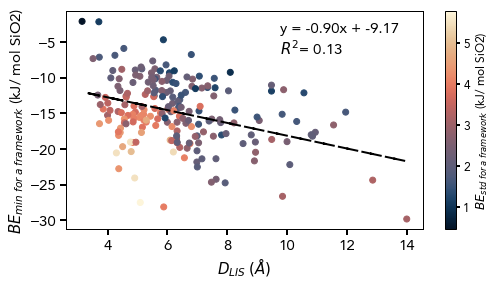

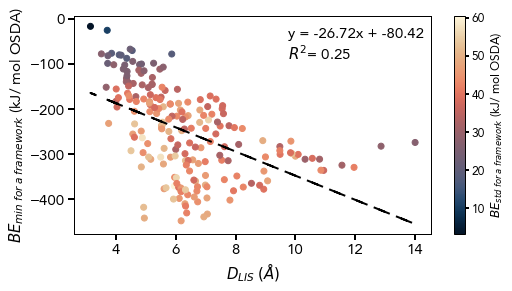

In [15]:
plot_correlations(truth, 'largest_included_sphere', "$D_{LIS} \; (\AA)$", "min", (0.6, 0.8))

#### BE_min-ASA

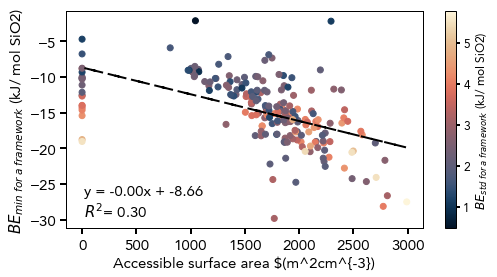

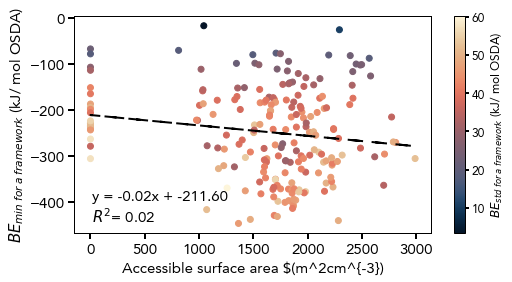

In [16]:
plot_correlations(truth, 'asa_m2_cm3', "Accessible surface area $(m^2cm^{-3})", "min", (0.05, 0.05))

#### BE_min-Total SA

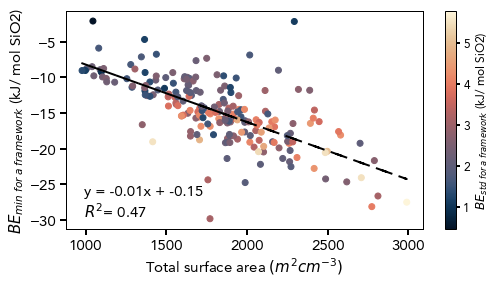

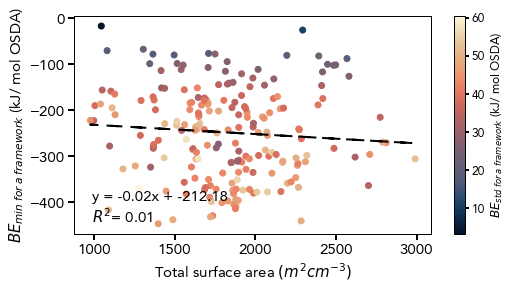

In [17]:
plot_correlations(truth, 'total_sa_m2_cm3', "Total surface area $(m^2cm^{-3})$", "min", (0.05, 0.05))

### CBUs

In [18]:
all_cbus = list()
for cbus in zpriors.cbus:
    if type(cbus) is list:
        all_cbus.extend(cbus)

In [19]:
len(set(all_cbus))

62

## Monoquaternary

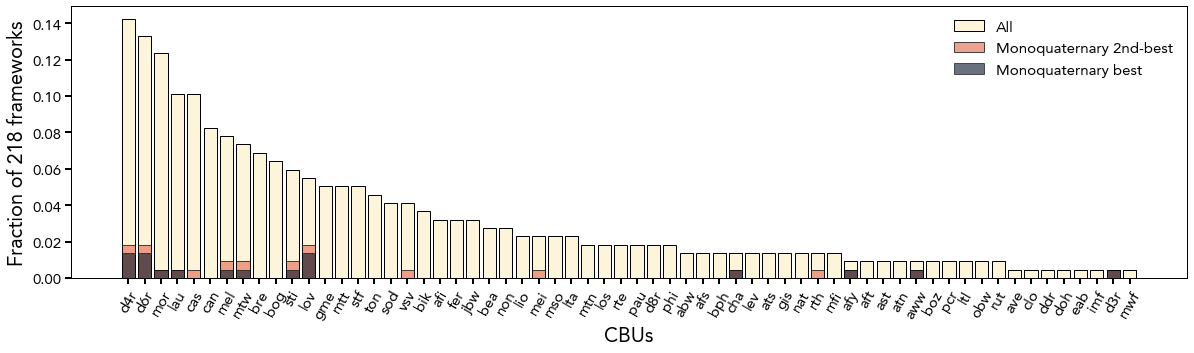

In [20]:
acc = Counter(all_cbus).most_common()

cbus = zpriors.loc[set(mono_df['best_fw'])].cbus
cbus = [a for b in cbus for a in b]
acc_best = Counter(cbus).most_common()

cbus = zpriors.loc[set(mono_df['second_fw'])].cbus
cbus = [a for b in cbus for a in b]
acc_second = Counter(cbus).most_common()

fig, axs = plt.subplots(figsize=(20, 5))
axs.bar([a[0] for a in acc], np.array([a[1] for a in acc]) / 218, color=colors[9], alpha=1.0, edgecolor='k');
axs = format_axs(axs, 15, 15, 1, "CBUs", "Fraction of 218 frameworks", 20, 20)
plt.xticks(rotation=60)

axs.bar([a[0] for a in acc_second], np.array([a[1] for a in acc_second]) / 218, color=colors[6], alpha=0.7, edgecolor='k');
axs.bar([a[0] for a in acc_best], np.array([a[1] for a in acc_best]) / 218, color=colors[0], alpha=0.6, edgecolor='k');

axs.legend(['All', 'Monoquaternary 2nd-best', 'Monoquaternary best'], fontsize=15, frameon=False);

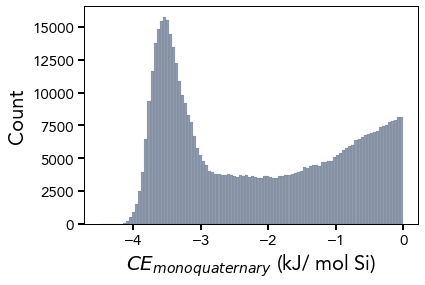

In [47]:
fig, axs = plt.subplots()
axs.hist(mono_df['ce'].values, bins=100, color=colors[2], edgecolor='k', alpha=0.6, linewidth=0.1);
axs = format_axs(axs, 15, 15, 1, "$CE_{monoquaternary}$ (kJ/ mol Si)", "Count", 20, 20)
mono_df[['SMILES', 'best_fw', 'ce']].to_csv(f"{source_data_dir}/fig_2/e_ce_distribution_mono.csv")
fig.savefig(f"{stats_op_dir}/ce_monoquaternary.svg", dpi=300, bbox_inches='tight')

## Diquaternary

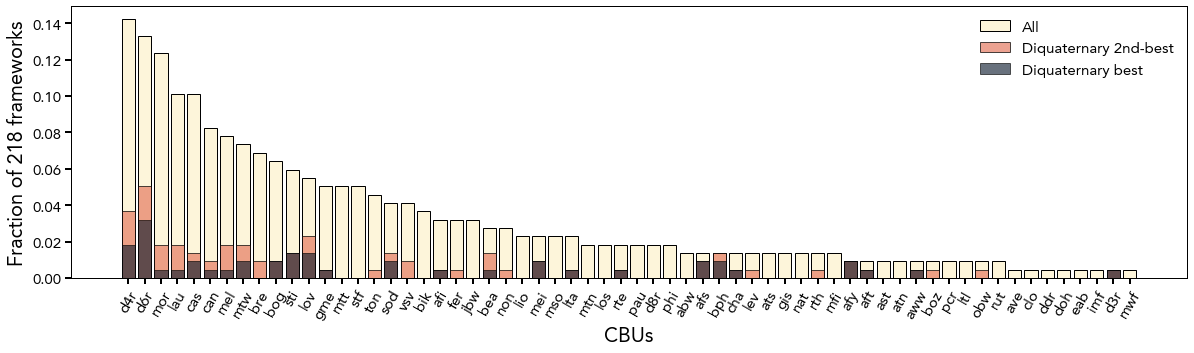

In [28]:
acc = Counter(all_cbus).most_common()

cbus = zpriors.loc[set(di_df['best_fw'])].cbus
cbus = [a for b in cbus for a in b]
acc_best = Counter(cbus).most_common()

cbus = zpriors.loc[set(di_df['second_fw'])].cbus
cbus = [a for b in cbus for a in b]
acc_second = Counter(cbus).most_common()

fig, axs = plt.subplots(figsize=(20, 5))
axs.bar([a[0] for a in acc], np.array([a[1] for a in acc]) / 218, color=colors[9], alpha=1.0, edgecolor='k');
axs = format_axs(axs, 15, 15, 1, "CBUs", "Fraction of 218 frameworks", 20, 20)
plt.xticks(rotation=60)

axs.bar([a[0] for a in acc_second], np.array([a[1] for a in acc_second]) / 218, color=colors[6], alpha=0.7, edgecolor='k');
axs.bar([a[0] for a in acc_best], np.array([a[1] for a in acc_best]) / 218, color=colors[0], alpha=0.6, edgecolor='k');

axs.legend(['All', 'Diquaternary 2nd-best', 'Diquaternary best'], fontsize=15, frameon=False);

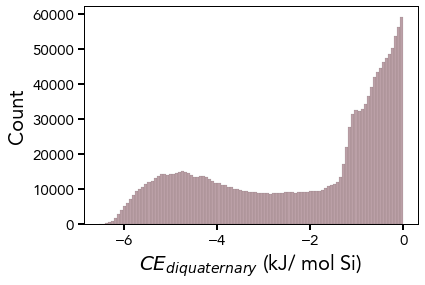

In [48]:
fig, axs = plt.subplots()
axs.hist(di_df['ce'].values, bins=100, color=colors[4], edgecolor='k', alpha=0.6, linewidth=0.1);
axs = format_axs(axs, 15, 15, 1, "$CE_{diquaternary}$ (kJ/ mol Si)", "Count", 20, 20)
di_df[['SMILES', 'best_fw', 'ce']].to_csv(f"{source_data_dir}/fig_2/e_ce_distribution_diq.csv")
fig.savefig(f"{stats_op_dir}/ce_diquaternary.svg", dpi=300, bbox_inches='tight')